# Lab 11. Spark MLlib oraz PyTorch.

W tym labie zaprezentowane zostaną przykładowe implementacje modelu Machine Learningowego głębokiej sieci neuronowej z wykorzystaniem biblioteki PyTorch. Najpierw zaprezentowany zostanie przykład bez wykorzystania PySpark, który można uruchomić na pojedynczej maszynie, a następnie przykład, który można skalować z wykorzystaniem klastra Spark.

PyTorch to aktualnie jedna z najbardziej popularnych bibliotek deep learningu na rynku. PyTorch wywodzi się oryginalnie z biblioteki Torch, która powstała pod skrzydłami Meta AI i pierwsza jej wersja została publicznie udostępniona w roku 2016. W roku 2017 powstał port w języku Python w postaci biblioteki PyTorch, która stała się bardziej popularna od swojego przodka. 

We wrześniu 2022 roku ogłoszono powstanie PyTorch Foundation, która jest częścią większej fundacji - Linux Foundation.
PyTorch jest wykorzystywany między innymi przez implementację transformerów (rodzaj sztucznej sieci nauronowej, która stoi za obecnym sukcesem modeli LLM w dziedzinie NLP) w bibliotece HuggingFace, w autopilocie firmy Tesla.

## 1. Przykład sieci neuronowej do klasyfikacji obrazów ze zbioru MNIST, bez wykorzystania Apache Spark

In [ ]:
# wymagane zainstalowanie biblioteki pytorch - ten proces wymaga pobrania znacznej ilości danych
# razem około 2GB
!pip install torch torchvision torchaudio

In [ ]:
# źródło i szczegółowe informacje o zbiorze danych MNIST
https://yann.lecun.com/exdb/mnist/

In [1]:
import argparse
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.optim.lr_scheduler import StepLR

In [3]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, 1)
        self.conv2 = nn.Conv2d(32, 64, 3, 1)
        self.dropout1 = nn.Dropout(0.25)
        self.dropout2 = nn.Dropout(0.5)
        self.fc1 = nn.Linear(9216, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)
        x = self.dropout1(x)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.dropout2(x)
        x = self.fc2(x)
        output = F.log_softmax(x, dim=1)
        return output


def train(args, model, device, train_loader, optimizer, epoch):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % args.log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))
            if args.dry_run:
                break


def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))


def main():
    # Training settings
    parser = argparse.ArgumentParser(description='PyTorch MNIST Example')
    parser.add_argument('--batch-size', type=int, default=64, metavar='N',
                        help='input batch size for training (default: 64)')
    parser.add_argument('--test-batch-size', type=int, default=1000, metavar='N',
                        help='input batch size for testing (default: 1000)')
    parser.add_argument('--epochs', type=int, default=14, metavar='N',
                        help='number of epochs to train (default: 14)')
    parser.add_argument('--lr', type=float, default=1.0, metavar='LR',
                        help='learning rate (default: 1.0)')
    parser.add_argument('--gamma', type=float, default=0.7, metavar='M',
                        help='Learning rate step gamma (default: 0.7)')
    parser.add_argument('--no-cuda', action='store_true', default=False,
                        help='disables CUDA training')
    parser.add_argument('--no-mps', action='store_true', default=False,
                        help='disables macOS GPU training')
    parser.add_argument('--dry-run', action='store_true', default=False,
                        help='quickly check a single pass')
    parser.add_argument('--seed', type=int, default=1, metavar='S',
                        help='random seed (default: 1)')
    parser.add_argument('--log-interval', type=int, default=10, metavar='N',
                        help='how many batches to wait before logging training status')
    parser.add_argument('--save-model', action='store_true', default=False,
                        help='For Saving the current Model')

    # EDIT - aby zadziałało uruchamianie w Jupyter Notebooku niezbędne jest dodania jeszcze obsługi argumentu -f
    parser.add_argument(
        '-f',
        '--file',
        help='Path for input file. First line should contain number of lines to search in'
    )

    args = parser.parse_args()
    use_cuda = not args.no_cuda and torch.cuda.is_available()
    use_mps = not args.no_mps and torch.backends.mps.is_available()

    torch.manual_seed(args.seed)

    if use_cuda:
        device = torch.device("cuda")
        print('Device: CUDA GPU')
    elif use_mps:
        device = torch.device("mps")
        print('Device: MPS')
    else:
        device = torch.device("cpu")
        print('Device: CPU')

    train_kwargs = {'batch_size': args.batch_size}
    test_kwargs = {'batch_size': args.test_batch_size}
    if use_cuda:
        cuda_kwargs = {'num_workers': 1,
                       'pin_memory': True,
                       'shuffle': True}
        train_kwargs.update(cuda_kwargs)
        test_kwargs.update(cuda_kwargs)

    transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,))
        ])
    dataset1 = datasets.MNIST('./data', train=True, download=True,
                       transform=transform)
    dataset2 = datasets.MNIST('./data', train=False,
                       transform=transform)
    train_loader = torch.utils.data.DataLoader(dataset1,**train_kwargs)
    test_loader = torch.utils.data.DataLoader(dataset2, **test_kwargs)

    model = Net().to(device)
    optimizer = optim.Adadelta(model.parameters(), lr=args.lr)

    scheduler = StepLR(optimizer, step_size=1, gamma=args.gamma)
    for epoch in range(1, args.epochs + 1):
        train(args, model, device, train_loader, optimizer, epoch)
        test(model, device, test_loader)
        scheduler.step()

    if args.save_model:
        torch.save(model.state_dict(), "mnist_cnn_2.pt")


if __name__ == '__main__':
    # main()
    pass

In [ ]:
# powyższy kod został również zapisany w oddzielnym pliku, co ułatwia jego uruchamianie z innymi niż domyślne wartościami parametrów
# uruchomienie z poziomu linii komend, wywołanie z argumentem --save-model, które zapisuje wytrenowany model do pliku
!python mnist_pytorch.py --save-model

In [ ]:
# instalacja paczek na potrzeby wizualizacji danych datasetu MNIST pobranych w poprzednim przykładzie
!pip install numpy idx2numpy matplotlib

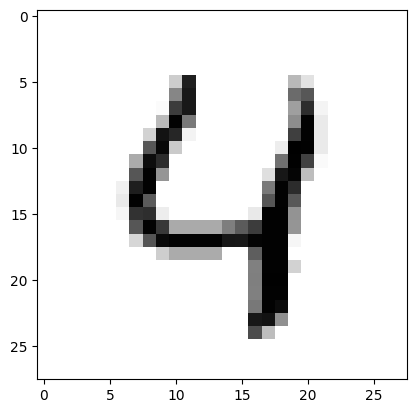

In [5]:
import numpy as np
import idx2numpy
import matplotlib.pyplot as plt

# ścieżka powinna być poprawna jeżeli nie dokonano modyfikacji przykładu powyżej
imagefile = './data/MNIST/raw/t10k-images-idx3-ubyte'
imagearray = idx2numpy.convert_from_file(imagefile)

# wizualizacja jednego obrazu (z tablicy numpy, dane do modelu podawane są w formie numerycznej)
plt.imshow(imagearray[4], cmap=plt.cm.binary);

**Inferencja z wcześniej wytrenowanego i zapisanego modelu PyTorch**

In [6]:
# inicjalizacja klasy modelu
model = Net()
# ładowanie wag modelu z pliku
model.load_state_dict(torch.load("mnist_cnn.pt", weights_only=True))
# ustawienie modelu w tryb ewaluacji (predykcji)
model.eval()

Net(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (dropout1): Dropout(p=0.25, inplace=False)
  (dropout2): Dropout(p=0.5, inplace=False)
  (fc1): Linear(in_features=9216, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=10, bias=True)
)

In [ ]:
# ustawiamy ile obrazów będzie ładowanych do tensora przy pojedynczej iteracji test loadera
batch_size = 8

transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize((0.1307,), (0.3081,))
            ])
test_kwargs = {'batch_size': batch_size}

# inicjalizacja zbioru jak w skrypcie głównym
dataset2 = datasets.MNIST('./data', train=False, transform=transform)

# inicjalizacja data loadera tak jak w głównej pętli
test_loader = torch.utils.data.DataLoader(dataset2, **test_kwargs)

<Figure size 640x480 with 0 Axes>

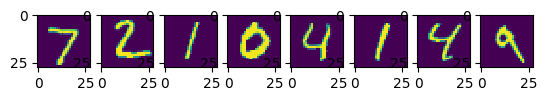

target: tensor([7, 2, 1, 0, 4, 1, 4, 9])
Prediction: tensor([7, 2, 1, 0, 4, 1, 4, 9])


<Figure size 640x480 with 0 Axes>

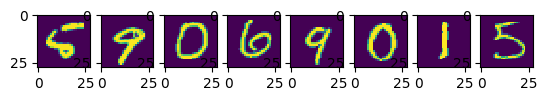

target: tensor([5, 9, 0, 6, 9, 0, 1, 5])
Prediction: tensor([5, 9, 0, 6, 9, 0, 1, 5])


<Figure size 640x480 with 0 Axes>

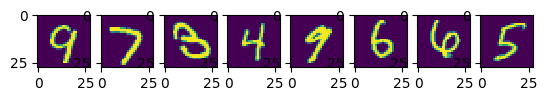

target: tensor([9, 7, 3, 4, 9, 6, 6, 5])
Prediction: tensor([9, 7, 3, 4, 9, 6, 6, 5])


<Figure size 640x480 with 0 Axes>

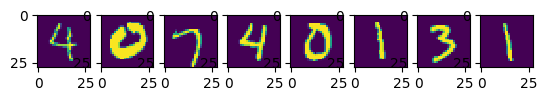

target: tensor([4, 0, 7, 4, 0, 1, 3, 1])
Prediction: tensor([4, 0, 7, 4, 0, 1, 3, 1])


<Figure size 640x480 with 0 Axes>

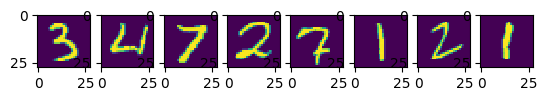

target: tensor([3, 4, 7, 2, 7, 1, 2, 1])
Prediction: tensor([3, 4, 7, 2, 7, 1, 2, 1])


In [21]:
# ustalenie ile iteracji ładowania danych z data loadera obsłuży poniższa pętla
# cały zbiór testowy zawiera 10k obrazów, więc nie chcemy ich tutaj wczystkich wyświetlać
# co na pewno zawiesiłoby przeglądarkę
batches = 5 # ostrożnie!
start = 0

for data, target in test_loader:
    plt.figure()
    f, axarr = plt.subplots(1, batch_size)
    for idx, img in enumerate(data):
        axarr[idx].imshow(img.squeeze(), interpolation='nearest')
    plt.show()
    print(f"target: {target}")
    with torch.no_grad():
        output = model(data)
        _, predicted_classes = torch.max(output, 1)
        print(f"Predykcja: {predicted_classes}")
    start += 1
    if start == batches:
        break

## Zadania

Rozwiązania odsyłamy w postaci zmodyfikowanej wersji tego notebooka (usuwamy cały pkt 2) z zaznaczeniem tam gdzie trzeba, którego zadania dotyczy wybrany jego fragment.

**Zadanie 1**  
Zainstaluj pakiet torch tak jak przedstawiono na pierwszych listingach jeżeli korzystasz z rozwiązania bazującego na przedstawionym wcześniej środowisku z wykorzystanie linuksowego kontenera dockerowego. Jeżeli nie, to sprawdź na stronie https://pytorch.org/get-started/locally/ jakie polecenie powinieneś/-aś wykonać w zależności od platformy.

**Zadanie 2**  
Uruchom przykład treningu sieci na zbiorze MNIST przedstawiony w przykładach.

**Zadanie 3**  
Jeżeli trening uruchamia się poprawnie wykonaj trening sieci raz jeszcze, ale teraz zapisz wagi wytrenowanego modelu do pliku (patrz przykład w materiałach).

**Zadanie 4**  
Korzystając z przykładów przedstawionych w tym notebooku zainicjalizuj klasę modelu wczytując wagi z zapisanego wcześniej pliku. Przeprowadź ewaluację 8 wsadów po 8 obrazów każdy ze zbioru testowego bzując na przykładach.

**Zadanie 5**  
Znajdź indeksy wszystkich niepoprawnie klasyfikowanych obrazów ze zbioru testowego i wyświetl 10 z tych obrazów wraz z informacjami jaka jest ich etykieta, a jaka predykcja.

**zadanie 6**  
> **OPCJONALNE!!!**

Jeżeli dysponujesz kartą graficzną z procesorami CUDA to utwórz kopię mechanizmu trenowania sieci zmieniając parametry tak, aby trening odbywał się z wykorzystaniem tej karty (tutaj konieczne będzie zainstalowanie Nvidia CUDA Toolkit oraz możliwe, że przeinstalowanie pakietu torch również. Patrz też tu:https://pytorch.org/get-started/locally/ 


# UWAGA! Poniższe listingi nie są aktualnie możliwe do poprawnego uruchomienia na konfiguracji, którą aktualnie posiadamy na zajęciach. Proszę to potraktować jako przykładowy workflow przy definiowaniu rozproszonych modeli z wykorzystaniem biblioteki PyTorch oraz PySpark.

## 2. Współbieżne dane oraz współbieżne modele.

Rozważając mechanizmy rozproszonego, współbieżnego ML rozróżniamy dwa główne podejścia:
* **współbieżność danych**,
* **współbieżność modelu**.

Istnieje jeszcze wiele pomniejszych rozwiązań, np. tzw współbieżność ekspertów (źródło: https://arxiv.org/pdf/2101.03961), a w praktyce dla największych modeli często wykorzystuje się mieszankę rozwiązań opartych o współbieżność danych oraz modeli. 

**Współbieżność danych** polega na podzieleniu danych na określoną liczbę części (nazywanych często w literaturze anglojęzycznej odłamkami, ang. data shards) i uruchomieniu tej samej logiki (modelu) na wielu węzłach, a następnie złączenie wyników. Jest to podejście najbardziej popularne i dużo łatwiejsze do zaimplementowania. Wykorzystywaliśmy je do tej pory w wielu przykładach poczynając od przykładów z wykorzystaniem multiprocessingu, poprzez bibliotekę Dask, a na Sparku kończąc jednak nie dla zadań związanych z Machine Learningiem.

Mamy więc do czynienia z wieloma instancjami tego samego modelu uruchamianego na wielu różnych fragmentach zbioru danych. Takie podejście można rozpisać na kolejne kroki:

1. Tworzenie kopii modelu i jego dystrybucja na każdy węzeł.
2. Podzielenie danych i ich dystrybucja na każde urządzenie (urządzenie może składać się więcej niż 1 workera, więc dane mogą być współdzielone między nimi).
3. Złączanie wyników w procesie propagacji wstecznej.

Możemy zauważyć, że krok 1 jest wykonywany raz na cały proces treningu modelu, ale kolejne kroki odbywają się już raz na iterację (pamiętajmy, że iteracja wykonywana jest na jednym wsadzie danych).

Biblioteka PyTorch dostarcza kilku modułów do tworzenia rozwiązań współnieżności danych i modeli:
* **DataParallel (DP)** - współnieżność danych, ale tylko na jednej maszynie,
* **Distributed Data Parallel (DDP)** - współbieżność danych na jednej lub wielu maszynach,
* **FullyShardedDataParallel (FSDP)** - współbieżność danych oraz modeli.

Te rozwiązania za pomocą modułu `torch.distributed` synchronizuje gradienty oraz bufory (czym jest bufor patrz [tu](https://pytorch.org/docs/stable/generated/torch.nn.parameter.Buffer.html) oraz [tu](https://discuss.pytorch.org/t/what-pytorch-means-by-buffers/120266)) pomiędzy procesami, które są wykorzystywane do aktualizacji modelu.

> Dokumentacja:
>
> **Pytorch Distributed API**: https://pytorch.org/tutorials/beginner/dist_overview.html#parallelism-apis
> 
> **Distributed Data Parallel tutorial**: https://pytorch.org/tutorials/intermediate/ddp_tutorial.html  
> **Distributed Data Parallel API klasy**: https://pytorch.org/docs/stable/generated/torch.nn.parallel.DistributedDataParallel.html#torch.nn.parallel.DistributedDataParallel  
> **FSDP Tutorial**: https://pytorch.org/tutorials/intermediate/FSDP_tutorial.html


**Współbieżne modele** to z kolei rozwiązanie, które jest wykorzystywane w sytuacji, w której na pojedynczym urządzeniu nie jest możliwe przechowanie i trenowanie całego modelu i wtedy potrzebny jest mechanizm podzielenia modelu między wiele węzłów i jego trenowanie we fragmentach. Oznacza to, że różne części grafu obliczeń modelu są uruchamiane na różnych urządzeniach, a wyniki treningu muszą być również odpowiednio transferowane między węzłami obliczeniowymi. Biorąc pod uwagę stopień skomplikowania zadania uczenia modelu głębokiej sieci neuronowej efektywne trenowanie takiego modelu jest wyzwaniem, ale w dobie modeli o skali modeli LLM rozwiązaniem koniecznym.

Do materiałów został dodany plik o nazwie **FSDP_mnist.py** pochodzący z oficjalnej dokumentacji biblioteki PyTorch, który jest przykładem wykorzystania mechanizmu FSDP pod kątem trenowania modelu na wielu kartach GPU, których niestety w chwili realizacji labu nie mamy do dyspozycji. Należy więc ten przykładowy kod potraktować jako lekcję teoretyczną.

In [18]:
# tutaj przykładowy kod modelu PyTorch z DDP
import torch.multiprocessing as mp

# inicjalizacja parametrów
BATCH_SIZE = 64
NUM_EPOCHS = 10
NUM_EXECUTERS = 1
LEARNING_RATE = 0.001
RANDOM_SEED_DEFAULT = 0

# definicja modelu
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, 1)
        self.conv2 = nn.Conv2d(32, 64, 3, 1)
        self.dropout1 = nn.Dropout(0.25)
        self.dropout2 = nn.Dropout(0.5)
        self.fc1 = nn.Linear(9216, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)
        x = self.dropout1(x)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.dropout2(x)
        x = self.fc2(x)
        output = F.log_softmax(x, dim=1)
        return output


# w przypadku treningu rozproszonego w PyTorch należy zainicjować wartość ziarna po to, aby
# uniknąć jego inicjalizacji na każdym węźle z osobna, co może negatywnie wpłynąć na stabilność całego procesu
def set_random_seeds(random_seed=0):
    torch.manual_seed(random_seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    np.random.seed(random_seed)
    random.seed(random_seed)


# setup inicjalizujący moduł torch.distributed ze wskazaniem backendu, tutal backend gloo
# ale mamy do wyboru jeszcze inne, np. nccl
def setup(rank, world_size, use_gpu=False):
    os.environ['MASTER_ADDR'] = 'localhost'
    os.environ['MASTER_PORT'] = '12355'

    # inicjalizacja backendu
    backend = "nccl" if use_gpu else "gloo"
    dist.init_process_group(backend, rank=rank, world_size=world_size)


# czyszczenie procesów po zakończeniu etapu uczenia
def cleanup():
    dist.destroy_process_group()


# funkcja do treningu, zmodyfikowana w kilku miejscach względem pierwotnej wersji
def train(args, model, rank, world_size, train_loader, optimizer, epoch):
    model.train()
    ddp_loss = torch.zeros(2).to(rank)
    
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(rank), target.to(rank)
        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target, reduction='sum')
        loss.backward()
        optimizer.step()
        ddp_loss[0] += loss.item()
        ddp_loss[1] += len(data)
        dist.all_reduce(ddp_loss, op=dist.ReduceOp.SUM)
        if rank == 0:
            print('Train Epoch: {} \tLoss: {:.6f}'.format(epoch, ddp_loss[0] / ddp_loss[1]))


def run_dist_training(rank, world_size):
    print(f"Running basic DDP example on rank {rank}.")
    setup(rank, world_size)

    # create model and move it to GPU with id rank
    model = Net().to(rank)
    ddp_model = DDP(model, device_ids=[rank])

    loss_fn = nn.MSELoss()
    # optimizer = optim.SGD(ddp_model.parameters(), lr=0.001)

    optimizer.zero_grad()
    outputs = ddp_model(torch.randn(20, 10))
    labels = torch.randn(20, 5).to(rank)
    loss_fn(outputs, labels).backward()
    optimizer.step()

    cleanup()
    print(f"Finished running basic DDP example on rank {rank}.")

In [ ]:
WORLD_SIZE = 2

mp.spawn(run_dist_training,
        args=(WORLD_SIZE, args),
        nprocs=WORLD_SIZE,
        join=True)

### Spark oraz PyTorch

Biblioteka Spark MLlib dostarcza interfejs do rozproszonego trenowania modelu opartego o bibliotekę PyTorch oraz PyTorch Lightning w API PySpark.

Całość odbywa się pooprzez klasę **TorchDistributor** dostępną w API PySpark:
https://spark.apache.org/docs/latest/api/python/reference/api/pyspark.ml.torch.distributor.TorchDistributor.html



In [ ]:
import findspark
from pyspark.sql import SparkSession

findspark.init()
spark = SparkSession\
        .builder\
        .master("local[2]")\
        .appName("Spark MLlib and PyTorch")\
        .getOrCreate()
spark.sparkContext

In [28]:
# przebudowany przykład treningu sieci z lokalnego treningu
import os
import argparse
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.optim.lr_scheduler import StepLR


class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, 1)
        self.conv2 = nn.Conv2d(32, 64, 3, 1)
        self.dropout1 = nn.Dropout(0.25)
        self.dropout2 = nn.Dropout(0.5)
        self.fc1 = nn.Linear(9216, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)
        x = self.dropout1(x)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.dropout2(x)
        x = self.fc2(x)
        output = F.log_softmax(x, dim=1)
        return output


def main_train(batch_size=64, num_epochs=10):
    #### importy powinny być dodane w głównej funkcji trenującej jeżeli chcemy ją przekazać
    #### później do TorchDistributor
    
    import torch.distributed as dist
    import torch.nn as nn
    from torch.nn.parallel import DistributedDataParallel as DDP
    from torch.utils.data.distributed import DistributedSampler
    
    # inicjalizacja backendu
    print("Running distributed training")
    # dist.init_process_group("nccl")
    dist.init_process_group("gloo")

    local_rank = int(os.environ["LOCAL_RANK"])
    global_rank = int(os.environ["RANK"])

    # definicja zbiorów danych
    transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.1307,), (0.3081,))])
    train_dataset = datasets.MNIST('./data', train=True, download=True, transform=transform)
    
    # dodajmy rozproszony data loader
    train_sampler = DistributedSampler(dataset=train_dataset)
    data_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, sampler=train_sampler)

    # inicjalizacja modelu
    model = Net().to(local_rank)
    # opakowanie w model rozproszony
    ddp_model = DDP(model, device_ids=[local_rank], output_device=local_rank)

    # tutaj zmienimy klasę optymalizatora z Adadelta na SGD
    optimizer = optim.SGD(ddp_model.parameters(), lr=learning_rate, momentum=momentum)
    # główna pętla treningu modelu
    for epoch in range(1, num_epochs + 1):
        train(ddp_model, local_rank, data_loader, optimizer, epoch)

    # testowanie
    if global_rank == 0:
    
        ddp_model.eval()
        
        test_dataset = datasets.MNIST('./data', train=False, transform=transform)
        test_data_loader = torch.utils.data.DataLoader(test_dataset)    
    
        test_loss = 0
        for data, target in test_data_loader:
            device = torch.device('cpu')
            data, target = data.to(device), target.to(device)
            output = ddp_model(data)
            test_loss += F.nll_loss(output, target)
              
        test_loss /= len(data_loader.dataset)
        print("Average test loss: {}".format(test_loss.item()))
    
    # zwolnienie zasobów uczenia rozproszonego
    dist.destroy_process_group()


In [ ]:
from pyspark.ml.torch.distributor import TorchDistributor

# kwargs = {"batch_size": 64, "num_epochs": 10}
distributor = TorchDistributor(num_processes=2, local_mode=True, use_gpu=False)
distributor.run(main_train)

25/01/08 12:16:15 WARN HeartbeatReceiver: Removing executor driver with no recent heartbeats: 316403 ms exceeds timeout 120000 ms
25/01/08 12:16:15 WARN SparkContext: Killing executors is not supported by current scheduler.


In [26]:
spark.stop()